# Topic Modeling Archival Newspapers

This data was taken from [this collection of digized New York Times articles](https://archive.org/details/pub_new-york-times). I have set up an example of how we can take a look at all of this data at once to think about a research question. I've limited the results to just issues released from 1918 to 1920, so that we can investigate the Spanish Flu.  

Below is a topic model, a computational technique we can use to show the relative importance and occurance of different words over a large corpus of text. All of the text is fed to the computer and is clustered according to how similar any given word's context is to another word. These cluster consistute "topics" that are present in the text. For a dataset like this one, we can plot the relevance of these topics over time. 

#### To get started, please go to "Cell > Run All"

Then, feel free to play around with the number of topics the computer should expect to see in the text. Observe how changing this parameter might change the results. 

#### Choose the number of topics:

In [1]:
%%capture
!wget https://tufts.box.com/shared/static/j5k9eez4o31zori8vqqqyj95530aevv8.csv -O spanish_flu_nyt.csv

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output

topic_amt = widgets.BoundedIntText(
    value=8,
    min=0,
    max=10,
    step=1,
    description='Topics:',
    disabled=False
)

display(topic_amt)

BoundedIntText(value=8, description='Topics:', max=10)

#### Once you have, click on the chart and then "▶ Run". Then wait a moment for the plot to be created.

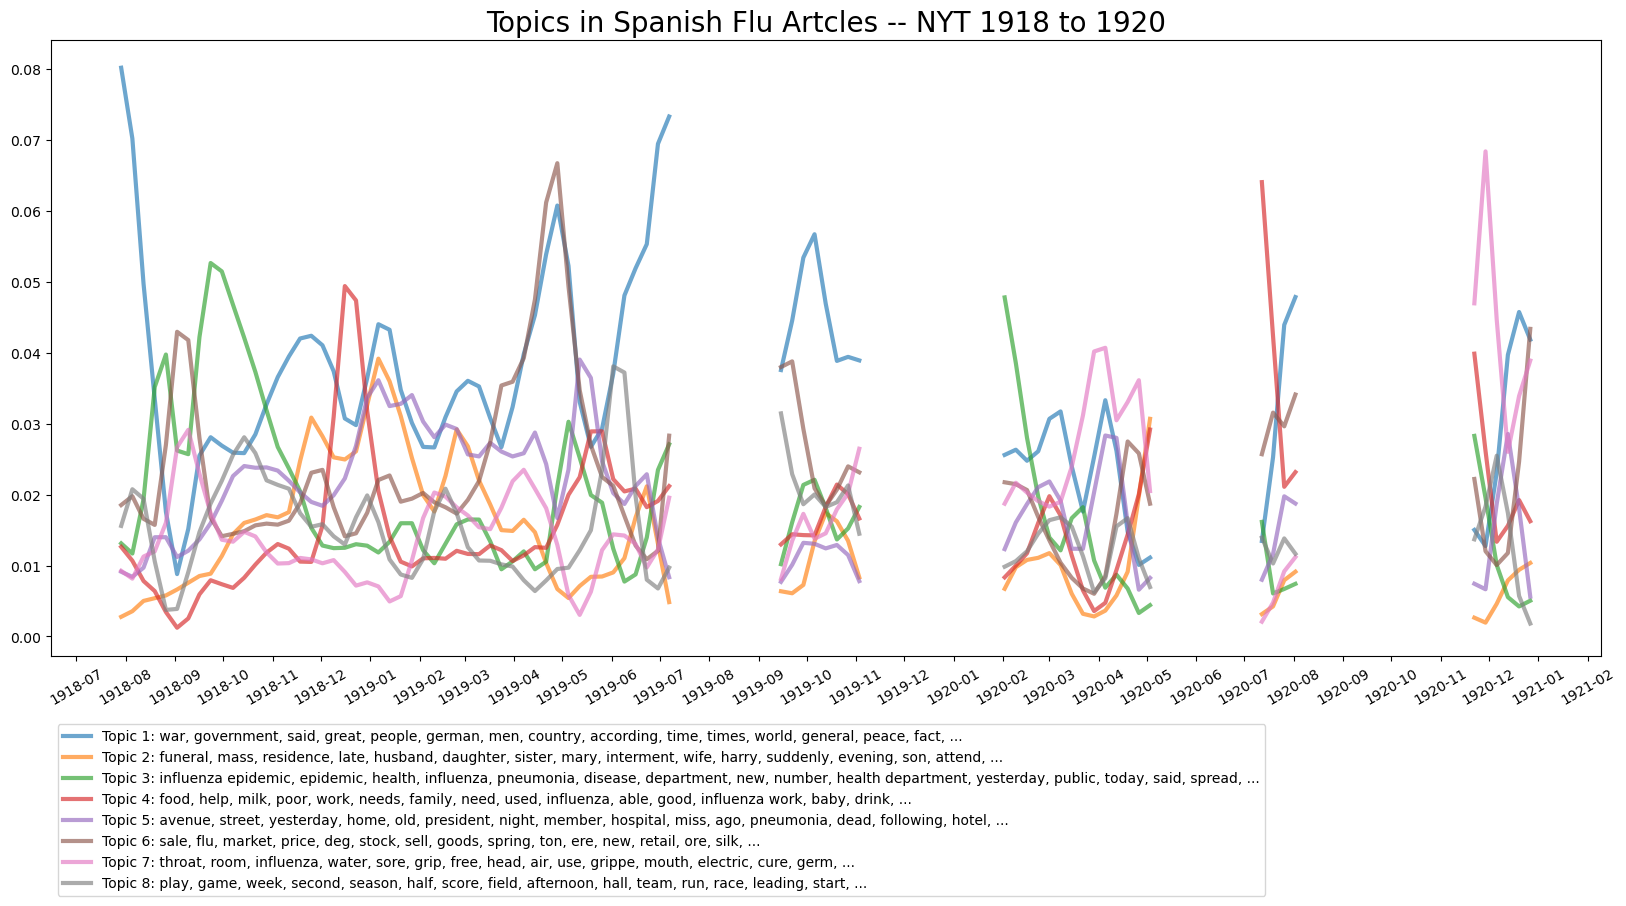

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

flu = pd.read_csv('spanish_flu_nyt.csv')
random.seed(42)

n_samples=flu.shape[0]
n_features = 1750
n_components = topic_amt.value
n_top_words = 20

data_samples = flu['clean_text']

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english", ngram_range=(1,3)
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
W = nmf.transform(tfidf)

flu['Date'] = flu['filename'].str.extract(r'(\d{4}-\d{2}-\d{2})')

articles_df_with_nmf_topics = flu.copy()
articles_df_with_nmf_topics.Date = articles_df_with_nmf_topics.Date.apply(pd.to_datetime)
for i in range(n_components):
    articles_df_with_nmf_topics[i] = nmf.transform(tfidf)[:,i]
    
nmf_sum_of_weights_by_week_df = articles_df_with_nmf_topics.groupby(pd.Grouper(key='Date', freq='W-MON'))[[i for i in range(n_components)]].sum()
nmf_count_of_articles_by_week_df = articles_df_with_nmf_topics.groupby(pd.Grouper(key='Date', freq='W-MON'))[[i for i in range(n_components)]].count()

nmf_count_of_articles_by_week_df = nmf_count_of_articles_by_week_df[[0]].reset_index().rename(columns={0:'num_articles'})

nmf_article_weights_and_counts = nmf_sum_of_weights_by_week_df.merge(nmf_count_of_articles_by_week_df, left_index=True, right_on='Date')
for i in range(n_components):
    nmf_article_weights_and_counts['normalized_'+ str(i)] = nmf_article_weights_and_counts[i]/ nmf_article_weights_and_counts['num_articles']
    
def construct_legend_label(topic, feature_names, n_top_words_for_legend):
    top_features_ind = topic.argsort()[: -n_top_words_for_legend - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    label = ''
    for word in top_features:
        label += word
        label += ', '
    label += "..."
    return label

n_top_words_for_legend = 15
feature_names = tfidf_vectorizer.get_feature_names_out()
fig, ax = plt.subplots(figsize=(20, 8))
linewidth=3
alpha=0.65

topic_dict = {}
for topic_num, topic in enumerate(nmf.components_):
    smoothed_topics = gaussian_filter1d(nmf_article_weights_and_counts['normalized_'+str(topic_num)], sigma=1)
    label = "Topic " + str(topic_num+1) + ": "
    label += construct_legend_label(topic, feature_names, n_top_words_for_legend)
    topic_dict[topic_num] = label.split(':')[1].replace('...', '').split(',')[:-1]
    ax.plot(nmf_article_weights_and_counts['Date'],smoothed_topics,label=label, linewidth=linewidth, alpha=alpha)

plt.title("Topics in Spanish Flu Artcles -- NYT 1918 to 1920", fontsize=20)
ax.legend(bbox_to_anchor=(0,-.1), loc="upper left")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.tick_params(axis='x', rotation=30)

flu_topics = articles_df_with_nmf_topics.copy().drop(['Date'], axis=1)
flu_topics['topic'] = flu_topics.apply(lambda x: np.argmax(x[-n_components:]), axis=1)
flu_topics['words'] = flu_topics['topic'].apply(lambda x: topic_dict[x])

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')